# Logistic Regression on Amazon Fine Food Reviews

# Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
* Given a review determine whether a review is positive or negative, by appling Logistic Regression algorithm and deciding the best Feature generation technique for given problem. Also to report the metrics for each iteration. Time based splitting to be followed.

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Import Packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import sqlite3
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from scipy.stats import expon

# 1. Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently. 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [4]:
# creating sql connection string
con = sqlite3.connect('../input/database.sqlite')

In [5]:
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3

filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [6]:
filtered_data.shape #looking at the number of attributes and size of the data
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# 3. Time Based Splitting

In [7]:
import datetime

filtered_data["Time"] = filtered_data["Time"].map(lambda t: datetime.datetime.fromtimestamp(int(t)).strftime('%Y-%m-%d %H:%M:%S'))

sortedData = filtered_data.sort_values('ProductId',axis=0,kind="quicksort", ascending=True)
final = sortedData.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep="first",inplace=False)

#sording data by timestamp so that it can be devided in train and test dataset for time based slicing.
final = final.sort_values('Time',axis=0,kind="quicksort", ascending=True).reset_index(drop=True)

print(final.shape)
final.head()

(364173, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,1999-10-08 00:00:00,EVERY book is educational,this witty little book makes my son laugh at l...
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,1999-10-25 00:00:00,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,1999-12-02 00:00:00,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
3,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,1999-12-06 00:00:00,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
4,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,2000-01-03 00:00:00,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...


# ****4.Exploratory Data Analysis****

4.1 Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data. Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...



As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that 

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

Observation:- It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [11]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [12]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

**4.2 Text Preprocessing: Stemming, stop-word removal and Lemmatization.**

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)
8. After which we collect the words used to describe positive and negative reviews

In [14]:
# find sentences containing HTML tags
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

8
What happens when you say his name three times? Michael Keaten stars in this comedy about two couples that live in an old two story house.  While coming back from a supply store, the couple suddenly get caught inside of a  &quot;broken-up&quot; bridge and then just before they start to tumble down  into the lake, a board catches them.  But just when they've got their hopes  up, and small dog steps on the board and the car starts to slide off the  bridge and into the lake waters.  A few minutes later...<p>They find  themselves back into their home, they find that somehow somehad light the  fireplace, as if done by magic.  From then on, they find a weird-looking  dead guy known as Bettlejuice.  The only way they can get him for help is  to call him by his name three times and he will appear at their survice.  But they soon wish that they have never called his name, because  Bettlejuice was once a troublemaker but he is the only one who can save  them, on the account that they said his 

In [15]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [16]:
# Data Sampling
final = final.iloc[:30000,:]
print(final.shape)
print(final['Score'].value_counts())

(30000, 10)
positive    26758
negative     3242
Name: Score, dtype: int64


In [17]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 10k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    i+=1

In [18]:
# Finding most frequently occuring Positive and Negative words 

freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(5))
print("Most Common Negative Words : ",freq_dist_negative.most_common(5))

Most Common Positive Words :  [(b'tast', 10739), (b'like', 10553), (b'tea', 10399), (b'good', 9024), (b'flavor', 8912)]
Most Common Negative Words :  [(b'tast', 1718), (b'like', 1559), (b'product', 1431), (b'one', 1071), (b'tri', 901)]


In [19]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,1999-10-08 00:00:00,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,1999-10-25 00:00:00,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,1999-12-02 00:00:00,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
3,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,1999-12-06 00:00:00,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
4,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,2000-01-03 00:00:00,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...


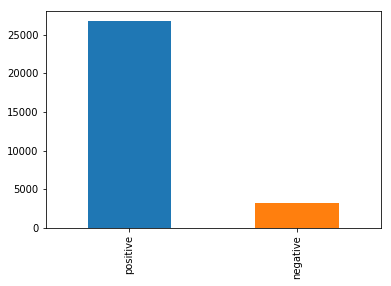

In [20]:
#Source:- https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots.html

final['Score'].value_counts().plot(kind='bar')

In [21]:
final.shape

(30000, 11)

# Observations:-
    
    * I've performed the following Data preprocessing.

        > Removed Stop-words
        
        > Removed any punctuations or limited set of special characters like , or . or # etc.
        
        > Snowball Stemming the word (The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form)
        
        > Converted the word to lowercase
        
    * I've added a column called 'CleanedText' which displays the data after pre-processing of the review. So,Now we have 1000 reviews with 11 columns
    
    * Out of 364k reviews, I 've sampled the data to 30k and applied Logistic Regression.
    
    * I've calculated the feature importance of both positive and negative classes and printed the top five most common words

In [22]:
#Split data into Train and Test Set
X_Train,X_Test,y_train,y_test = train_test_split(final['CleanedText'],final['Score'],random_state = 0,test_size = 0.3)

# 5. Applying LogisticRegression with Grid and Random Search (l2 Regularization)

In [23]:
# Function to run Logistic Regression with GridSearchCV and RandomSearchCV
def RunLR(X_Train,X_Test,y_train,y_test,Search_Type):    
    lb_make = LabelEncoder()
    
    y_train_encoded = lb_make.fit_transform(y_train)
    y_test_encoded = lb_make.fit_transform(y_test)
    
    if (Search_Type == 'grid'):
        tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
        GS_L2_model = GridSearchCV(LogisticRegression(),tuned_parameters,cv = 5,scoring = 'f1')
        GS_L2_model.fit(X_Train,y_train_encoded)
        print(GS_L2_model.best_estimator_)
        print('The Score with '+ Search_Type+ 'search CV is: '+ str(GS_L2_model.score(X_Test, y_test_encoded)))
        print('*' * 100)
    elif (Search_Type == 'random'):
        random_parameters = dict(C=[1, 10, 100, 1000])  
        RS_L2_model = RandomizedSearchCV(LogisticRegression(),random_parameters,cv = 5,scoring = 'f1',n_jobs= 1, n_iter=4)
        RS_L2_model.fit(X_Train,y_train_encoded)
        print(RS_L2_model.best_estimator_)
        print('The Score with '+ Search_Type+ 'search CV is: ' + str(RS_L2_model.score(X_Test, y_test_encoded)))
        print('*' * 250)

# 6. Applying LogisticRegression with Grid and Random Search (l1 Regularization)

In [24]:
# Function to run Logistic Regression with GridSearchCV and RandomSearchCV
def RunLRl1(X_Train,X_Test,y_train,y_test,Search_Type):    
    lb_make = LabelEncoder()
    
    y_train_encoded = lb_make.fit_transform(y_train)
    y_test_encoded = lb_make.fit_transform(y_test)
    
    
    if (Search_Type == 'grid'):
        tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
        GS_L1_model = GridSearchCV(LogisticRegression(penalty='l1'),tuned_parameters,cv = 5,scoring = 'f1')
        GS_L1_model.fit(X_Train,y_train_encoded)
        print(GS_L1_model.best_estimator_)
        print('The Score with '+ Search_Type+ 'search CV is: '+ str(GS_L1_model.score(X_Test, y_test_encoded)))
        print('*' * 100)
    elif (Search_Type == 'random'):
        random_parameters = dict(C=[1, 10, 100, 1000])  
        RS_L1_model = RandomizedSearchCV(LogisticRegression(penalty='l1'),random_parameters,cv = 5,scoring = 'f1',n_jobs= 1, n_iter=4)
        RS_L1_model.fit(X_Train,y_train_encoded)
        print(RS_L1_model.best_estimator_)
        print('The Score with '+ Search_Type+ 'search CV is: ' + str(RS_L1_model.score(X_Test, y_test_encoded)))

# Observations:-

* I 've splitted the data into train, test and cross validation data set.
    
* I've build a function to run Logistic Regression with both l1 & l2 regularizer's using GridSearchCV and Random SearchCV.
    
* I've performed 5-fold Cross validation and considered 'f1' as scoring measure and printed the best estimator

# 7. Feature Generation Techniques

**7.1 Bag of Words (BOW)**

In [25]:
# BoW Vectorization

vect = CountVectorizer().fit(X_Train)
X_Train_vectorised = vect.transform(X_Train)
X_Test_vectorised = vect.transform(X_Test)


RunLR(X_Train_vectorised,X_Test_vectorised,y_train,y_test,'grid')
RunLR(X_Train_vectorised,X_Test_vectorised,y_train,y_test,'random')

RunLRl1(X_Train_vectorised,X_Test_vectorised,y_train,y_test,'grid')
RunLRl1(X_Train_vectorised,X_Test_vectorised,y_train,y_test,'random')

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
The Score with gridsearch CV is: 0.9618180707434786
****************************************************************************************************
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
The Score with randomsearch CV is: 0.9618180707434786
**********************************************************************************************************************************************************************************************************************************************************
LogisticRegressi

**7.2 Using TF-IDF**

In [26]:
# Applying TFIDF

vect_tfidf = TfidfVectorizer(min_df = 5).fit(X_Train)
X_Train_vectorised = vect_tfidf.transform(X_Train)
X_Test_vectorised = vect_tfidf.transform(X_Test)
RunLR(X_Train_vectorised,X_Test_vectorised,y_train,y_test,'grid')
RunLR(X_Train_vectorised,X_Test_vectorised,y_train,y_test,'random')

RunLRl1(X_Train_vectorised,X_Test_vectorised,y_train,y_test,'grid')
RunLRl1(X_Train_vectorised,X_Test_vectorised,y_train,y_test,'random')

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
The Score with gridsearch CV is: 0.9599856450744662
****************************************************************************************************
LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
The Score with randomsearch CV is: 0.9631569331952987
**********************************************************************************************************************************************************************************************************************************************************
LogisticRegress

**7.3 Using Word2Vec**

In [27]:
#Splitting into TRaining and Testing Set, and using only Training set for Word2Vec Training
X_Train,X_Test,y_train,y_test = train_test_split(final['Text'],final['Score'])


# Train your own Word2Vec model using your own text corpus
# Function to clean punctuations and special characters

def cleanpunct(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

i=0
list_of_sent=[]
for sent in X_Train.values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunct(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [28]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)    
words = list(w2v_model.wv.vocab)

In [29]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in X_Train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

X_train_Vectorised = sent_vectors

sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in X_Test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

X_test_Vectorised = sent_vectors

np.where(np.isnan(X_test_Vectorised))
X_train_Vectorised = np.nan_to_num(X_train_Vectorised)
X_test_Vectorised = np.nan_to_num(X_test_Vectorised)

RunLR(X_train_Vectorised,X_test_Vectorised,y_train,y_test,'grid')
RunLR(X_train_Vectorised,X_test_Vectorised,y_train,y_test,'random')

RunLRl1(X_train_Vectorised,X_test_Vectorised,y_train,y_test,'grid')
RunLRl1(X_train_Vectorised,X_test_Vectorised,y_train,y_test,'random')

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
The Score with gridsearch CV is: 0.9412013834968589
****************************************************************************************************
LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
The Score with randomsearch CV is: 0.941126641253706
**********************************************************************************************************************************************************************************************************************************************************
LogisticReg

**7.4 Using TF-IDF Weighted Word2Vec**

In [30]:
#Splitting into TRaining and Testing Set, and using only Training set for Word2Vec Training
X_Train,X_Test,y_train,y_test = train_test_split(final['Text'],final['Score'])

# TF-IDF weighted Word2Vec
vect_tfidf = TfidfVectorizer(min_df = 5).fit(X_Train)
tfidf_feat = vect_tfidf.get_feature_names() # tfidf words/col-names

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in X_Train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = vect_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    
    #print(type(sent_vec))
    try:
        sent_vec /= weight_sum
    except:
        pass
    
    tfidf_sent_vectors.append(sent_vec)
    row += 1
X_train_Vectorised = tfidf_sent_vectors


tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in X_Test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = vect_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    
    #print(type(sent_vec))
    try:
        sent_vec /= weight_sum
    except:
        pass
    
    tfidf_sent_vectors.append(sent_vec)
    row += 1

X_test_Vectorised = tfidf_sent_vectors
    
X_train_Vectorised = np.nan_to_num(X_train_Vectorised)
X_test_Vectorised = np.nan_to_num(X_test_Vectorised)
    
RunLR(X_train_Vectorised,X_test_Vectorised,y_train,y_test,'grid')
RunLR(X_train_Vectorised,X_test_Vectorised,y_train,y_test,'random')

RunLRl1(X_train_Vectorised,X_test_Vectorised,y_train,y_test,'grid')
RunLRl1(X_train_Vectorised,X_test_Vectorised,y_train,y_test,'random')

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
The Score with gridsearch CV is: 0.9415749364944962
****************************************************************************************************
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
The Score with randomsearch CV is: 0.9415749364944962
**********************************************************************************************************************************************************************************************************************************************************
LogisticReg

# Sparsity Check

In [33]:
# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C) 

import numpy as np

vect = CountVectorizer().fit(X_Train)
X_Train_vectorised = vect.transform(X_Train)

clf = LogisticRegression(C=0.1, penalty='l1');
clf.fit(X_Train_vectorised, y_train);
w = clf.coef_
print(np.count_nonzero(w))

374


In [34]:
vect = CountVectorizer().fit(X_Train)
X_Train_vectorised = vect.transform(X_Train)

clf = LogisticRegression(C=0.01, penalty='l1');
clf.fit(X_Train_vectorised, y_train);
w = clf.coef_
print(np.count_nonzero(w))

43


In [35]:
vect = CountVectorizer().fit(X_Train)
X_Train_vectorised = vect.transform(X_Train)

clf = LogisticRegression(C=0.001, penalty='l1');
clf.fit(X_Train_vectorised, y_train);
w = clf.coef_
print(np.count_nonzero(w))

2


In [36]:
vect = CountVectorizer().fit(X_Train)
X_Train_vectorised = vect.transform(X_Train)

clf = LogisticRegression(C=10, penalty='l1');
clf.fit(X_Train_vectorised, y_train);
w = clf.coef_
print(np.count_nonzero(w))

3293


# Observations

* I've applied Logistic Regression with both 'l1' & 'l2' Regularizer's using GridSearchCV and RandomSearchCV on Amazon Fine Food Review Data Set and applied four feature generation techniques. Below is the tabular result

# 8. Logistic Regression on Amazon Fine Food Reviews Data set - Tabular Result

In [11]:
#Creating Table for l2 Regularization

import pandas as pd
print('Logistic Regression (l2 Regularizer)')
dataframe = pd.DataFrame(
{
    "Model": ['BOW','TF-IDF','WORD2VEC','AVG W2V'],
    "GridSearchCV (C=)": [1,1,0.0001,0.0001],
    "GridSearchCV_Accuracy (%)": [96.18,95.99,94.12,94.15],
    "RandomSearchCV (C=)": [1,10,10,1],
    "RandomSearchCV_Accuracy (%)": [96.18,96.31,94.11,94.15],
}

)
dataframe

Logistic Regression (l2 Regularizer)


,Model,GridSearchCV (C=),GridSearchCV_Accuracy (%),RandomSearchCV (C=),RandomSearchCV_Accuracy (%)
0,BOW,1.0000,96.18,1,96.18
1,TF-IDF,1.0000,95.99,10,96.31
2,WORD2VEC,0.0001,94.12,10,94.11
3,AVG W2V,0.0001,94.15,1,94.15


In [12]:
#Creating Table for l2 Regularization

import pandas as pd
print('Logistic Regression (l1 Regularizer)')
dataframe = pd.DataFrame(
{
    "Model": ['BOW','TF-IDF','WORD2VEC','AVG W2V'],
    "GridSearchCV (C=)": [1,1,0.01,0.01],
    "GridSearchCV_Accuracy (%)": [96.08,96.23,94.12,94.15],
    "RandomSearchCV (C=)": [1,1,1,1],
    "RandomSearchCV_Accuracy (%)": [96.07,96.23,94.11,94.15],
}

)
dataframe

Logistic Regression (l1 Regularizer)


,Model,GridSearchCV (C=),GridSearchCV_Accuracy (%),RandomSearchCV (C=),RandomSearchCV_Accuracy (%)
0,BOW,1.00,96.08,1,96.07
1,TF-IDF,1.00,96.23,1,96.23
2,WORD2VEC,0.01,94.12,1,94.11
3,AVG W2V,0.01,94.15,1,94.15


# 9. Conclusion: 
    
* The result of feature generation techniques and machine learning algorithms vary by application. But by comparing the accuracy of all 4 developed models, Logistic Regression (l2 regularizer) with RandomSearchCV on TF-IDF feature generation technique gives accuracy more than 96.31% which is the best to predict the polarity of reviews among all models. The best optimal lamda value is 10.